In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
from scipy.stats import multivariate_normal

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import jax

import time
import pycbc.conversions as conv
import corner

from gwbench import injections
from gwbench import network
from gwbench import snr

In [3]:
save_likelihoods = False

# plotdir = 'power_law_hyper_param_plots/'
plotdir = 'power_law_m2_lim_hyper_param_plots/'

# likelihood_dir = 'power_law_-3.5_5_100_likelihoods/'
likelihood_dir = 'power_law_-3.5_5_100_m2_lim_likelihoods/'

alpha_inj = -3.5

# https://en.wikipedia.org/wiki/Inverse_distribution says that for a uniformly distributed r.v. X where p(X) = 1/(b-a)
# Y = 1/X is distributed as g(Y) = Y^-2 / (b-a)
beta_inj = 0.0


mmin_inj = 5.0
# mmax_inj = 100.
mmax_inj = 60.

bias_index=1

import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)

# Read simulation

In [4]:
# File with Mc biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_2400_4800.csv', \
    # 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_7200_10080.csv']


# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc_2400_10080.csv']

files = [f'powerlaw_3.5_lams_m2_lim/powerlaw_alpha_3.5_lam_0_1_Mc_0_9600.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
df_mc_raw = df_mc_raw[(df_mc_raw["m1"]/(1+df_mc_raw["z"])) <= 60.]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 9105


In [5]:
# File with eta biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_2400_4800.csv', \
#     'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_7200_10080.csv']

# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta_2400_10080.csv']

files = [f'powerlaw_3.5_lams_m2_lim/powerlaw_alpha_3.5_lam_0_1_eta_0_9600.csv']



df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
df_eta_raw = df_eta_raw[(df_eta_raw["m1"]/(1+df_eta_raw["z"])) <= 60.]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 9105


## Sample from the events if needed

In [6]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

print(len(df_mc))
print(np.median(df_mc["Mc"]))

9105
20.590229726828472


In [7]:
df_mc.reset_index(inplace = True,drop = True)
df_eta.reset_index(inplace = True,drop = True)

$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

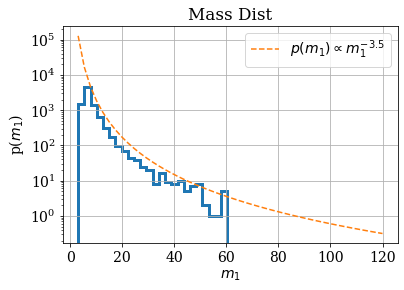

In [8]:
bins = np.linspace(3, 120, 50)

m1_inj = df_mc["m1"]/(1+df_mc["z"])
# y, X = np.histogram(m1_inj, bins=bins, density=True)
# X = X[:-1]
# plt.plot(X, y, 'bo', label='Injected')

plt.hist(m1_inj, bins, histtype='step', lw=3)
plt.plot(bins, 6000000*bins**(alpha_inj), linestyle='--', label='$p(m_1) \propto m_1^{-3.5}$')
plt.grid()
plt.semilogy()

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")
plt.title("Mass Dist")
plt.legend()

# plt.xlim(3, 7)

# plt.savefig("powerlaw_3.5_plots/powerlaw_m1_dist.pdf")
plt.show()

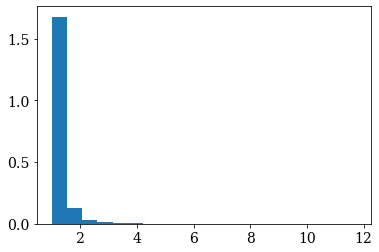

In [9]:
# bins=np.geomspace(0.00001,4.0, 30)

# plt.hist(df_mc_raw["bias_1"], bins=bins, density=True)
# plt.hist(df_mc_raw["bias_1"][df_mc_raw["Mc"]>20], bins=bins, density=True, histtype="step")
# plt.semilogx()
# plt.show()
# plt.hist(df_eta_raw["bias_1"], bins=bins, density=True)
# plt.hist(df_eta_raw["bias_1"][df_eta_raw["snr"]>8], bins=bins, density=True, histtype="step")
# plt.semilogx()
# plt.show()

# plt.hist(df_eta_raw["snr"], bins=np.geomspace(1, 500, 30))
# plt.semilogx()
# plt.show()

plt.hist(df_mc_raw["q"], bins=20, density=True)
# plt.semilogx()
plt.show()

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [10]:
def sample_m1_events(df_mc, df_eta, biased=False, bias_index=19, injected=False):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc_raw = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)

    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
    m1_sigma_events = m1_sigma_events.values

    if biased:
        bias_mc = df_mc[f"bias_{bias_index}"]
        bias_eta = df_eta[f"bias_{bias_index}"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    # m1_mu_sampled = stats.truncnorm.rvs(0, 1000, m1_mu_detections, m1_sigma_events)
    m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

    if injected:
        m1_mu_sampled = m1_mu_detections.values

    return m1_mu_sampled, m1_sigma_events 

In [11]:
def sample_m2_events(df_mc, df_eta, biased=False, bias_index=19, injected=False):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc_raw = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m2_mu_detections = df_mc["m2"] / (1+z)

    aux0=0.25*((((-1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
    aux2=(((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+aux2
    m2_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
    m2_sigma_events = m2_sigma_events.values

    

    if biased:
        bias_mc = df_mc[f"bias_{bias_index}"]
        bias_eta = df_eta[f"bias_{bias_index}"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m2_mu_detections = conv.mass2_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    # m2_mu_sampled = stats.truncnorm.rvs(0, 1000, m2_mu_detections, m2_sigma_events)
    m2_mu_sampled = np.random.normal(m2_mu_detections, m2_sigma_events)

    if injected:
        m2_mu_sampled = m2_mu_detections.values

    return m2_mu_sampled, m2_sigma_events #, m2_mu_detections

In [12]:
def sample_m1_m2_events(df_mc, df_eta, biased=False, bias_index=19, injected=True):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)
    m2_mu_detections = df_mc["m2"] / (1+z)

    # compute variance of m1
    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m1_variance = m1_variance.values

    # compute variance of m2
    aux0=0.25*((((-1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
    aux2=(((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+aux2
    m2_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m2_variance = m2_variance.values

    # compute covariance of m1 and m2
    aux0=(0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*((sigMc**2)*(((1.+(1.*z))**2))))
    aux1=(-0.09*((1.+(-4.*eta))**2.))+((((1.+(-4.*eta))**1.)*(0.09+(-0.6*eta)))+(-1.*(eta**2)))
    aux2=((0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*(sigZ**2)))+(((1.+(-4.*eta))**-1.)*(aux1*((sigEta**2)*(((1.+(1.*z))**2)))))
    m1_m2_covariance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+((mchirp**2)*aux2)))
    m1_m2_covariance = m1_m2_covariance.values

    if biased:
        bias_mc = df_mc[f"bias_{bias_index}"]
        bias_eta = df_eta[f"bias_{bias_index}"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible
        # eta_biased = df_mc["eta"]+bias_eta

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        m2_mu_detections = conv.mass2_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    m1_mu_sampled = np.random.normal(m1_mu_detections, np.sqrt(m1_variance))
    m2_mu_sampled = np.random.normal(m2_mu_detections, np.sqrt(m2_variance))

    if injected:
        m1_mu_sampled = m1_mu_detections.values
        m2_mu_sampled = m2_mu_detections.values

    return m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance

In [13]:
def log_integral(prior, posteriors, m1_int_range):
    # make sure the prior is normalized 
    # (becomes a problem with geomspaced bins where the first few numbers are 0s)
    prior = prior / integrate.trapezoid(prior, m1_int_range)
    
    integrands = prior*posteriors
    integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
    
    integrals = integrals[integrals!=0]
    
    return np.sum(np.log(integrals))

In [14]:
def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A
    # return stats.norm.pdf(m1, loc=mu, scale=sigma)

def trunc_normal_dist(m1, mu, sigma, m_min=None, m_max=None):
    if m_min is None:
        m_min = np.min(m1)
    if m_max is None:
        m_max = np.max(m1)
        
    a, b = (m_min - mu) / sigma, (m_max - mu) / sigma
    return stats.truncnorm.pdf(m1, a, b, loc = mu, scale = sigma)

def sigmoid(x, a):
    return 1/(1 + np.exp(a-x))

In [15]:
def bivariate_normal_dist(m1, m2, mu1, mu2, cov):
    sig1 = np.sqrt(cov[0,0])
    sig2 = np.sqrt(cov[1,1])
    sig12 = cov[0,1]

    rho = sig12 / (sig1 * sig2)

    Z = ((m1-mu1)**2 / (sig1)**2) + ((m2-mu2)**2 / (sig2)**2) - ((2*rho*(m1-mu1)*(m2-mu2)) / (sig1*sig2))

    A = 2*np.pi * sig1 * sig2 * np.sqrt(1-(rho**2))

    return np.exp(-(Z / (2 * (1 - rho**2)))) / A

In [16]:
m1 = 5.0
m2 = 3.0
mu1 = 4.5
mu2 = 3.0
cov = np.array([[1,-0.4], [-0.4,1]])


sig1 = np.sqrt(cov[0,0])
sig2 = np.sqrt(cov[1,1])
sig12 = cov[0,1]

rho = sig12 / (sig1 * sig2)

Z = ((m1-mu1)**2 / (sig1)**2) + ((m2-mu2)**2 / (sig2)**2) - ((2*rho*(m1-mu1)*(m2-mu2)) / (sig1*sig2))

A = 2*np.pi * sig1 * sig2 * np.sqrt(1-(rho**2))

np.exp(-(Z / (2 * (1 - rho**2)))) / A

0.14964194127072053

In [137]:
m1_min_int=5.0
m_min_prior = 4.96
m1_max_int=100
alpha=-3.5


m1 = np.geomspace(m1_min_int, m1_max_int, 10000)
print(integrate.trapezoid(power(m1, alpha, m1_min_int, m1_max_int), m1))

p_interp = interpolate.InterpolatedUnivariateSpline(m1, power(m1, alpha, m_min_prior, m1_max_int))

print(integrate.trapezoid(p_interp(m1), m1))
# print(integrate.trapezoid(p_m1(m1, alpha, m_min_prior, m1_max_int), m1))

0.9999999083729039
0.9801088516515597


In [138]:
m1_min = 5.0
m1_max = 100
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 34
sigma = 1.4

print(integrate.trapezoid(normal_dist(m1, mu, sigma), m1))

1.0


In [139]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 134
sigma = 1.4
print(integrate.trapezoid(trunc_normal_dist(m1, mu, sigma), m1))

1.0000025188661694


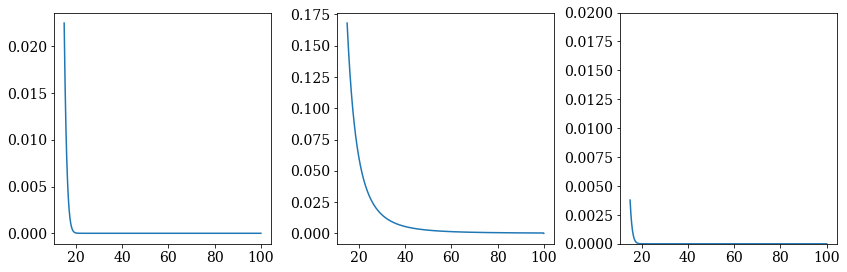

In [140]:
# Visualize the defined functions for sanity

m1_min=15
m1_max=100

m1 = np.linspace(m1_min, m1_max, 1000)
mu = 10.2
sigma = 2.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, power(m1, alpha, m1_min, m1_max))
# ax2.set_xlim(0, 20)
ax3.plot(m1, (normal_dist(m1, mu, sigma)*power(m1, alpha, m1_min, m1_max)))

plt.ylim(0, 0.02)

plt.tight_layout()
plt.show()


# Compute 1D Hyper posterior

In [17]:
def get_cofidence_int_1d(log_norm, range):
    # 68% confidence interval using KDE
    cdf_likelihood = integrate.cumulative_trapezoid(np.exp(log_norm), range, initial=0)
    cdf_likelihood = cdf_likelihood/np.max(cdf_likelihood)

    # make sure the cdf is strictly increasing to interpolate
    index_min = np.where(cdf_likelihood == np.min(cdf_likelihood))[0][0]
    index_max = np.where(cdf_likelihood == np.max(cdf_likelihood))[0][0]

    inv_cdf_interp = interpolate.interp1d(cdf_likelihood[index_min:index_max], range[index_min:index_max], fill_value="extrapolate")


    med = inv_cdf_interp(0.5)
    sig_pos = inv_cdf_interp(0.84)
    sig_neg = inv_cdf_interp(0.16)

    return med, sig_pos, sig_neg

## $\alpha$ hyper-posterior

In [147]:
save_likelihoods = True

In [141]:
def log_likelihood_alpha(m1_mu_events, m2_mu_events, covariances, \
    alpha_min=-4.0, alpha_max=-2.0, n_alpha=30, \
    beta=beta_inj, \
    m1_min_pow=mmin_inj, m1_max_pow=mmax_inj,\
    m1_min_int = 5.0, m1_max_int=60., n_m1_int=10000, n_m2_int = 100,\
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)
    
    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    log_p_alpha = np.zeros(n_alpha)

    integrand_m2 = np.zeros((Nt, n_m1_int))    

    for a in range(n_alpha):
        alpha = alpha_range[a]

        prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
        prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)


        for j in range(n_m1_int):
            m2_int_range = np.linspace(m1_min_int, m_int_range[j], n_m2_int)
            priors_m2 = power(m2_int_range, beta, m1_min_pow, m_int_range[j])
            for i in range(Nt):
                posteriors_m2 = bivariate_normal_dist(m_int_range[j], m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i])
                integrand_m2[i,j] = integrate.trapezoid(priors_m2 * posteriors_m2, m2_int_range)    

        integrands = prior_m1 * integrand_m2
        integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
        integrals = integrals[integrals!=0]
        log_p_alpha[a] = np.sum(np.log(integrals))
        
    return log_p_alpha, alpha_range


In [29]:
# def log_likelihood_alpha(m1_mu_events, m1_sigma_events, \
#     alpha_min=-4.5, alpha_max=-3, n_alpha=30, \
#         m1_min_int = 5., m1_max_int=200., n_m1_int=10000, \
#         m1_min_pow = 5., m1_max_pow=200., \
#             Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
#     m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
    
#     alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
#     log_p_alpha = np.zeros(n_alpha)

#     posteriors = np.zeros((Nt, n_m1_int))
#     for i in range(Nt):
#         posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])

#     for a in range(n_alpha):
#         alpha = alpha_range[a]
#         prior = power(m1_int_range, alpha, m1_min_pow, m1_max_pow)
        
#         log_p_alpha[a] = log_integral(prior, posteriors, m1_int_range)
        
#     return log_p_alpha, alpha_range


### $\lambda$=0, alpha posterior

In [142]:
# # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
# m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc, df_eta, injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [148]:
alpha_min = alpha_inj-0.20
alpha_max=alpha_inj+0.20
n_alpha=30

alpha_range_lam_0 = np.linspace(alpha_min, alpha_max, n_alpha)
fname_alpha_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_0"    

In [149]:
log_p_alpha_lam_0_src, alpha_range_lam_0 = log_likelihood_alpha(m1_mu_sampled, m2_mu_sampled, covariances,\
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_min_int = mmin_inj, m1_max_int=mmax_inj, n_m1_int=300, n_m2_int=300,\
    m1_min_pow = mmin_inj, m1_max_pow=mmax_inj,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_alpha_norm_lam_0 =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_alpha_lam_0, log_alpha_norm_lam_0)


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [150]:
# Load likelihoods from file
# log_alpha_norm_lam_0 = np.loadtxt(fname_alpha_lam_0)

In [151]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_0, alpha_range_lam_0)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.516176300156534, -3.487446174359175, -3.4588111732539653
Injected alpha is 0.438 sigma away


most likely alpha (IN SOURCE FRAME) = -3.487446174359175


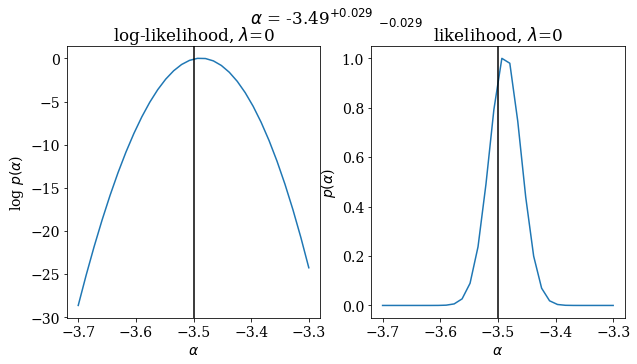

In [160]:
print("most likely alpha (IN SOURCE FRAME) =",med_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_0, log_alpha_norm_lam_0)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(alpha_range_lam_0, np.exp(log_alpha_norm_lam_0))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda$=1, alpha posterior

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True, bias_index=bias_index)

In [ ]:
bins = np.geomspace(3, 150, 50)

m1_inj = df_mc["m1"] / (1+df_mc["z"])
y, X = np.histogram(m1_inj, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'bo', label='Injected')

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'ro', label='Biased')

plt.xlabel("m1")
plt.ylabel("Prob")
plt.legend()

plt.semilogy()
plt.show()

From the Mathematica nb, a small increase in both Mc and eta results in lower m1, higher m2. The biased m1s are lower for high masses, which makes the power-law slope steeper.

In [ ]:
alpha_min = alpha_inj-1.0
alpha_max=alpha_inj+0.50
n_alpha=100

alpha_range_lam_1 = np.linspace(alpha_min, alpha_max, n_alpha)
fname_alpha_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_1"    

In [ ]:
log_p_alpha_lam_1, alpha_range_lam_1 = log_likelihood_alpha(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_min_int = mmin_inj, m1_max_int=mmax_inj, n_m1_int=10000,\
    m1_min_pow = mmin_inj, m1_max_pow=mmax_inj,\
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))

log_alpha_norm_lam_1 =log_p_alpha_lam_1 - np.max(log_p_alpha_lam_1)

# Save likelihoods to file
if save_likelihoods:   
    np.savetxt(fname_alpha_lam_1, log_alpha_norm_lam_1)

In [ ]:
# Load likelihoods from file
# log_alpha_norm_lam_1 = np.loadtxt(fname_alpha_lam_1)

In [ ]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_alpha_norm_lam_1), alpha_range_lam_1
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

bias_sigma = ((mu_alpha - alpha_inj)/sig_alpha)
print(rf"Injected alpha is {bias_sigma :.2f} sigma away")

In [ ]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_1, alpha_range_lam_1)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


In [ ]:
print("most likely alpha (IN SOURCE FRAME) =", mu_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_1, log_alpha_norm_lam_1)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(alpha_range_lam_1, np.exp(log_alpha_norm_lam_1))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

## m_min hyper-posterior [OLD]

In [29]:
save_likelihoods = True

In [30]:
def log_likelihood_mmin(m1_mu_events, m1_sigma_events, m2_mu_events, m2_sigma_events, \
    alpha=-3.5, beta=-2.0,\
    m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
    m1_min_int=3.0, m1_max_int=200., n_m1_int=20000, n_m2_int=200, \
    m1_max_pow=60., \
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros(n_m1_low)

    m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

    integrand_m2 = np.zeros((Nt, n_m1_int))
    priors_m2 = np.zeros((n_m1_int, n_m1_int))

    posteriors_m1 = np.zeros((Nt, n_m1_int))    
    posteriors_m2 = np.zeros((Nt, n_m1_int))

    for i in range(Nt):
        posteriors_m1[i] = normal_dist(m_int_range, m1_mu_events[i], m1_sigma_events[i])

    for m1_low_index, m1_low in enumerate(m1_low_range):

        # priors_m2 = np.zeros((n_m1_int, n_m1_int))

        # posteriors_m1 = np.zeros((Nt, n_m1_int))
        # posteriors_m2 = np.zeros((Nt, n_m1_int))

        prior_m1 = power(m_int_range, alpha, m1_low, m1_max_pow)
        prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)


        # for j in range(n_m1_int):
        #     priors_m2[j] = power(m_int_range, beta, m1_low, m_int_range[j])
        #     norm_p2 = integrate.trapezoid(priors_m2[j])
        #     if norm_p2 != 0:
        #         priors_m2[j] = priors_m2[j]/norm_p2
        for j in range(n_m1_int):
            m2_int_range = np.geomspace(m1_min_int, m_int_range[j], n_m2_int)
            priors_m2 = power(m2_int_range, beta, m1_low, m_int_range[j])
            norm_p2 = integrate.trapezoid(priors_m2)
            if norm_p2 != 0:
                priors_m2 = priors_m2/norm_p2
                
            for i in range(Nt):
                posteriors_m2 = normal_dist(m2_int_range, m2_mu_events[i], m2_sigma_events[i])
                integrand_m2[i,j] = integrate.trapezoid(priors_m2 * posteriors_m2, m2_int_range)
          
        # integrand_m2 = jax.numpy.matmul(priors_m2, posteriors_m2.T).T

        integrands = prior_m1*posteriors_m1*integrand_m2 


        
        #     posteriors_m2[i] = normal_dist(m_int_range, m2_mu_events[i], m2_sigma_events[i])

        
        # # this block of code actually works, confirmed (although it 'integrates' along m2 using np.sum())
        # integrand_m2 = jax.numpy.matmul(priors_m2, posteriors_m2.T).T

        # integrands = prior_m1*posteriors_m1*integrand_m2       

        integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
        integrals = integrals[integrals!=0]
        log_likelihoods[m1_low_index] = np.sum(np.log(integrals))

        
    return log_likelihoods, m1_low_range

In [ ]:
# def log_likelihood_mmin(m1_mu_events, m1_sigma_events, \
#     alpha=-3.5, \
#     m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#     m1_max_int=200., n_m1_int=20000, \
#     m1_max_pow=200., \
#         Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
#     m1_min_int = m1_low_min

#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

#     m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

#     posteriors = np.zeros((Nt, n_m1_int))
#     for i in range(Nt):
#         posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
    
#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
        
#         prior = power(m1_int_range, alpha, m1_min_pow, m1_max_pow)
#         log_likelihoods[m1_low_index] = log_integral(prior, posteriors, m1_int_range)

#         # prior_interp = interpolate.InterpolatedUnivariateSpline(m1_int_range, prior)
#         # log_likelihoods[m1_low_index] = log_integral(prior_interp(m1_int_range), posteriors, m1_int_range)
        
#     return log_likelihoods, m1_low_range


In [ ]:
# def log_likelihood_mmin(m1_mu_events, m1_sigma_events, m2_mu_events, m2_sigma_events,\
#     alpha=-3.5, \
#     m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#     m1_max_int=200., n_m1_int=20000, \
#     m1_max_pow=200., \
#         Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
#         m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

#         m2_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

#         total_int = 0

#         for i in range(Nt):
#             # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
#             # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
#             # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
#             p_m2 = power(m2_int_range, beta_inj, m1_min_pow, m1_mu_events[i])
#             integrand_m2 = p_m2 * normal_dist(m1_int_range, m2_mu_events[i], m2_sigma_events[i])
#             m2_int_term = integrate.trapezoid(integrand_m2, m2_int_range)

#             integrand = m2_int_term * power(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
#             int_term = integrate.trapezoid(integrand, m1_int_range)
#             if int_term==0:
#                 int_term=1

#             total_int = total_int + np.log(Ns) + np.log(int_term)
            
#         log_likelihoods[m1_low_index] = -Ns + total_int
        
#     return log_likelihoods, m1_low_range

### $\lambda=0$, m_min posterior

In [31]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)
m2_mu_sampled, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=False)

In [32]:
m1_low_min = 4.97
m1_low_max= 5.05
n_m1_low= 10

m1_low_range_lam_0 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_0"    

In [33]:
log_p_mmin_lam_0, m1_low_range_lam_0 = log_likelihood_mmin(m1_mu_sampled, m1_sigma_events, \
    m2_mu_sampled, m2_sigma_events,                                                       
    alpha=alpha_inj, beta=beta_inj,\
    m1_low_min =m1_low_min, m1_low_max =m1_low_max, n_m1_low=n_m1_low,\
    m1_min_int = m1_low_min, m1_max_int=mmax_inj, n_m1_int=500, n_m2_int=500, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm_lam_0 =log_p_mmin_lam_0 - np.max(log_p_mmin_lam_0)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_mmin_lam_0, log_mmin_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


KeyboardInterrupt: 

In [ ]:
# Load likelihoods from file
# log_mmin_norm_lam_0 = np.loadtxt(fname_mmin_lam_0)

In [ ]:
# # 68% confidence interval assuming Normal Distribution
# target_func = normal_dist
# y, X = np.exp(log_mmin_norm_lam_0), m1_low_range_lam_0
# popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

# mu_mmin = popt[0]
# sig_mmin = popt[1]
# print(popt)

# bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
# print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

In [ ]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_0, m1_low_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


In [ ]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_0, log_mmin_norm_lam_0)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].scatter(m1_low_range_lam_0, np.exp(log_mmin_norm_lam_0))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("$p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_min posterior

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True, bias_index=bias_index)
m2_mu_sampled_biased, m2_sigma_events_biased = sample_m2_events(df_mc, df_eta, biased=True, bias_index=bias_index)

In [ ]:
m1_low_min = 5.0
m1_low_max= 5.3
n_m1_low=20

m1_low_range_lam_1 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_1"    

In [ ]:
log_p_mmin_lam_1, m1_low_range_lam_1 = log_likelihood_mmin(m1_mu_sampled_biased, m1_sigma_events_biased, \
    m2_mu_sampled_biased, m2_sigma_events_biased,                                                       
    alpha=alpha_inj, beta=beta_inj,\
    m1_low_min =m1_low_min, m1_low_max =m1_low_max, n_m1_low=n_m1_low,\
    m1_min_int = 4.9, m1_max_int=mmax_inj, n_m1_int=10000, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm_lam_1 =log_p_mmin_lam_1 - np.max(log_p_mmin_lam_1)

# Save likelihoods to file
if save_likelihoods:   
    np.savetxt(fname_mmin_lam_1, log_mmin_norm_lam_1)

In [ ]:
# Load likelihoods from file
# log_mmin_norm_lam_1 = np.loadtxt(fname_mmin_lam_1)

In [ ]:
# # 68% confidence interval assuming Normal Distribution
# target_func = normal_dist
# y, X = np.exp(log_mmin_norm_lam_1), m1_low_range_lam_1
# popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

# mu_mmin = popt[0]
# sig_mmin = popt[1]
# print(popt)

# bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
# print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

In [ ]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_1, m1_low_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


In [ ]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_1, log_mmin_norm_lam_1)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_low_range_lam_1, np.exp(log_mmin_norm_lam_1))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("log $p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

## m_min hyper posterior with Bivariate integrals

In [34]:
save_likelihoods = True

In [35]:
def log_likelihood_mmin_2D(m1_mu_events, m2_mu_events, covariances, \
    alpha=-3.5, beta=-2.0,\
    m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
    m1_min_int=3.0, m1_max_int=200., n_m1_int=500, n_m2_int=200, \
    m1_max_pow=60., \
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros(n_m1_low)

    m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

    integral_m2 = np.zeros((Nt, n_m1_int))

    integrands = np.zeros((Nt, n_m1_int))


    for m1_low_index, m1_low in enumerate(m1_low_range):

        prior_m1 = power(m1_int_range, alpha, m1_low, m1_max_pow)
        prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_int_range)

        for j, m1 in enumerate(m1_int_range):
            m2_int_range = np.geomspace(m1_min_int, m1, n_m2_int)
            prior_m2 = power(m2_int_range, beta, m1_low, m1)
            norm_p2 = integrate.trapezoid(prior_m2, m2_int_range)
            if norm_p2 != 0:
                prior_m2 = prior_m2/norm_p2
                
            for i in range(Nt):
                posteriors_m2 = bivariate_normal_dist(m1, m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i])
                integral_m2[i,j] = integrate.trapezoid(prior_m2 * posteriors_m2, m2_int_range)
          
        integrands = prior_m1*integral_m2

        integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
        integrals = integrals[integrals!=0]
        log_likelihoods[m1_low_index] = np.sum(np.log(integrals))

        
    return log_likelihoods, m1_low_range

In [36]:
# def log_likelihood_mmin_2D(m1_range, m2_range, posteriors,\
#     alpha=-3.5, beta=0.0,\
#     m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#     m1_max_pow=200., \
#         Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

    
#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
        
#         # set the prior on m2
#         prior_m2_full = power(m2_range, beta, m1_min_pow, m1_range[-1])
#         prior_m2 = np.tri(len(m1_range), len(m2_range)) * prior_m2_full
#         norm = integrate.trapezoid(prior_m2, m2_range, axis=1)
#         norm[np.where(norm==0)]=1.0
#         prior_m2 = prior_m2 / norm[:, np.newaxis]

#         # compute the integral over m2
#         integrals_m2 = np.zeros((len(posteriors), len(m1_range)))
#         for i in range(len(posteriors)): 
#             integrals_m2[i] = np.sum(np.dot(prior_m2 , np.transpose(posteriors[i])), axis=0)

#         # # try without m2 prior
#         # integrals_m2 = np.zeros((len(posteriors), len(m1_range)))
#         # for i in range(len(posteriors)):
#         #     integrals_m2[i] = integrate.trapezoid(posteriors[0], m2_range, axis=1)

#         # set the prior on m1
#         prior_m1 = power(m1_range, alpha, m1_min_pow, m1_max_pow)
#         prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_range)

#         # compute the integral over m1
#         m1_integrand = prior_m1 * integrals_m2
#         log_likelihoods[m1_low_index] = np.sum(np.log(integrate.trapezoid(m1_integrand, m1_range, axis=1)))
        
        
#     return log_likelihoods, m1_low_range

### $\lambda=0$, m_min posterior

In [37]:
# set the required data (takes ~ 1 min for 1000 events)
m1_mu_detections, m2_mu_detections,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_detections), 2,2))

for i in range(len(m1_mu_detections)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [38]:
m1_low_min = 4.9
m1_low_max = 5.1
n_m1_low = 30

m1_low_range_lam_0 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_detections)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_0"    

In [39]:
log_p_mmin_lam_0, m1_low_range_lam_0 = log_likelihood_mmin_2D(m1_mu_detections, m2_mu_detections, covariances, \
    alpha=alpha_inj, beta=beta_inj,\
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_min_int=m1_low_min, m1_max_int=40., n_m1_int=800, n_m2_int=400, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_detections), Nt=len(m1_mu_detections))
    
log_mmin_norm_lam_0 =log_p_mmin_lam_0 - np.max(log_p_mmin_lam_0)


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [40]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_0, m1_low_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")

68% Confidence interval: 5.005337410906652, 5.010152901336391, 5.014973005080045
Injected mmin is 2.106 sigma away


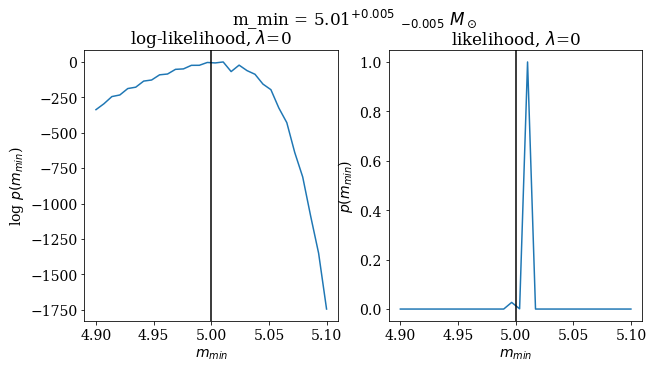

In [42]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_0, log_mmin_norm_lam_0)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_low_range_lam_0, np.exp(log_mmin_norm_lam_0))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("$p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

plt.savefig(plotdir+f'N_{len(m1_mu_detections)}_mmin_hyper_posterior_lam_0.pdf')
plt.show()

## m_max hyper-posterior

In [60]:
def log_likelihood_mmax_2D(m1_mu_events, m2_mu_events, covariances, \
    alpha=-3.5, beta=0.,\
    m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
    m1_min_int=5., m1_max_int=100., n_m1_int=300, n_m2_int=300, \
    m1_min_pow=5.0, \
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)
    log_likelihoods = np.zeros(n_m1_high)

    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

    integral_m2 = np.zeros((Nt, n_m1_int))

    integrands = np.zeros((Nt, n_m1_int))


    for m1_high_index, m1_high in enumerate(m1_high_range):

        prior_m1 = power(m1_int_range, alpha, m1_min_pow, m1_high)
        prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_int_range)

        for j, m1 in enumerate(m1_int_range):
            m2_int_range = np.linspace(m1_min_int, m1, n_m2_int)
            prior_m2 = power(m2_int_range, beta, m1_min_pow, m1)
            norm_p2 = integrate.trapezoid(prior_m2, m2_int_range)
            if norm_p2 != 0:
                prior_m2 = prior_m2/norm_p2
                
            for i in range(Nt):
                posteriors_m2 = bivariate_normal_dist(m1, m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i])
                integral_m2[i,j] = integrate.trapezoid(prior_m2 * posteriors_m2, m2_int_range)
          
        integrands = prior_m1*integral_m2

        integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
        integrals = integrals[integrals!=0]
        log_likelihoods[m1_high_index] = np.sum(np.log(integrals))

        
    return log_likelihoods, m1_high_range

In [ ]:
# def log_likelihood_mmax(m1_mu_events, m1_sigma_events, \
#     alpha=alpha_inj, \
#     m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
#     m1_min_int=5., m1_max_int=100., n_m1_int=20000, \
#     m1_min_pow=5., \
#     Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
#     m1_max_int=m1_high_max
    
#     m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)
#     log_likelihoods = np.zeros(n_m1_high)

#     m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

#     posteriors = np.zeros((Nt, n_m1_int))
#     for i in range(Nt):
#         posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])

#     for m1_high_index in range(n_m1_high):
#         m1_max_pow = m1_high_range[m1_high_index]
#         prior = power(m1_int_range, alpha, m1_min_pow, m1_max_pow)
#         log_likelihoods[m1_high_index] = log_integral(prior, posteriors, m1_int_range)
            
        
#     return log_likelihoods, m1_high_range

### $\lambda=0$, m_max posterior

In [61]:
# # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
# m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [62]:
m1_high_min = mmax_inj - 20.
m1_high_max= mmax_inj + 30.
n_m1_high=40

m1_high_range_lam_0 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
fname_mmax_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_0"    

In [63]:
log_p_mmax_lam_0, m1_high_range_lam_0 = log_likelihood_mmax_2D(m1_mu_sampled, m2_mu_sampled, covariances, \
    alpha=alpha_inj,
    m1_high_min =m1_high_min, m1_high_max =m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=mmin_inj, n_m1_int=300, n_m2_int=300, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmax_norm_lam_0 =log_p_mmax_lam_0 - np.max(log_p_mmax_lam_0)

# # Save likelihoods to file
if save_likelihoods:   
    np.savetxt(fname_mmax_lam_0, log_mmax_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [64]:
# # Load likelihoods from file
# log_mmax_norm_lam_0 = np.loadtxt(fname_mmax_lam_0)

In [65]:
# # 68% confidence interval assuming Normal Distribution
# target_func = normal_dist
# y, X = np.exp(log_mmax_norm_lam_0), m1_high_range_lam_0
# popt, pcov = optimize.curve_fit(target_func, X, y, p0=[60., 0.6, 1.0])

# mu_mmax = popt[0]
# sig_mmax = popt[1]
# print(popt)

# bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
# print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

In [66]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_0, m1_high_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 60.60002445556917, 62.1397843573922, 64.45537607992055
Injected mmin is 0.924 sigma away


most likely m1_max (IN SOURCE FRAME) = 62.1397843573922


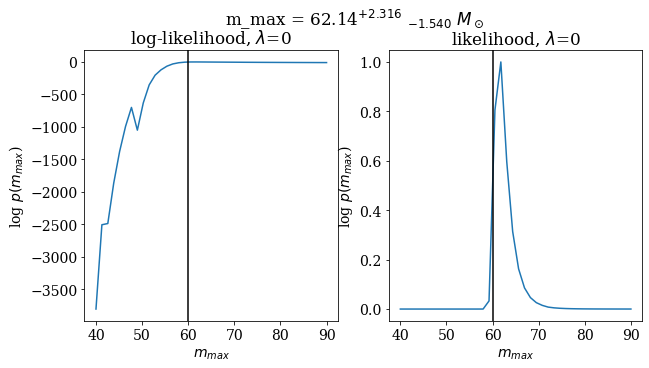

In [67]:
print("most likely m1_max (IN SOURCE FRAME) =",med_mmax)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_0, log_mmax_norm_lam_0)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_high_range_lam_0, np.exp(log_mmax_norm_lam_0))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_max posterior

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True, bias_index=bias_index)

In [ ]:
# mask = (m1_mu_sampled_biased>50)
# print((m1_mu_sampled_biased)[mask])
# # df_mc[mask]["bias_19"]/ (df_mc[mask]["z"]+1)
# # df_mc[mask]["Mc_stat_err"]
# # df_mc[mask]

# m1 = np.linspace(5, 250, 500)
# for i in range(np.sum(mask)):
#     m1_mu = m1_mu_sampled_biased[mask][i]
#     m1_sig = m1_sigma_events_biased[mask][i]
#     plt.plot(m1, stats.norm.pdf(m1, loc=m1_mu, scale=m1_sig))

In [ ]:
np.max(m1_mu_sampled_biased)

In [ ]:
m1_high_min = mmax_inj - 20.0
m1_high_max= mmax_inj + 100.
n_m1_high = 50

m1_high_range_lam_1 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
fname_mmax_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_1"    

In [ ]:
log_p_mmax_lam_1, m1_high_range_lam_1 = log_likelihood_mmax(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha=alpha_inj,
    m1_high_min=m1_high_min, m1_high_max=m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=mmin_inj, m1_max_int=300., n_m1_int=10000, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))
    
    
log_mmax_norm_lam_1 =log_p_mmax_lam_1 - np.max(log_p_mmax_lam_1)

# # Save likelihoods to file
if save_likelihoods:   
    np.savetxt(fname_mmax_lam_1, log_mmax_norm_lam_1)

In [ ]:
# # Load likelihoods from file
# log_mmax_norm_lam_1 = np.loadtxt(fname_mmax_lam_1)

In [ ]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmax_norm_lam_1), m1_high_range_lam_1
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[60., 0.6, 1.0])

mu_mmax = popt[0]
sig_mmax = popt[1]
print(popt)

bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

In [ ]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_1, m1_high_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


In [ ]:
# print(f"most likely m1_max (IN SOURCE FRAME) = {m1_high_range_lam_1[np.argmax(log_mmax_norm_lam_1)]:.3f}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_1, log_mmax_norm_lam_1)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_high_range_lam_1, np.exp(log_mmax_norm_lam_1))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

In [ ]:
bins = np.geomspace(5, 400, 30)

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()



plt.figure(figsize=(10, 5))
plt.plot(X, power(X,  alpha_inj, mmin_inj, med_mmax), '--', label='Best-Fit')

plt.plot(X, power(X,  alpha_inj, mmin_inj, mmax_inj), '--', label='Simulated')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(30, 70)

plt.show()

## beta hyper-posterior

In [49]:
def log_likelihood_beta(m1_mu_events, m2_mu_events, covariances, \
    beta_min=-3.5, beta_max=1.0, n_beta=30, \
    alpha=alpha_inj, \
    m1_min_pow=mmin_inj, m1_max_pow=mmax_inj,\
    m1_min_int = 5.0, m1_max_int=60., n_m1_int=10000, n_m2_int = 100,\
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)
    
    beta_range = np.linspace(beta_min, beta_max, n_beta)
    log_p_beta = np.zeros(n_beta)

    # priors_m2 = np.zeros((n_m1_int, n_m1_int))

    integral_m2 = np.zeros((Nt, n_m1_int))
    integrands = np.zeros((Nt, n_m1_int))

    prior_m1 = power(m1_int_range, alpha, m1_min_pow, m1_max_pow)
    prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_int_range)


    for b in range(n_beta):
        beta = beta_range[b]

        for j, m1 in enumerate(m1_int_range):
            m2_int_range = np.geomspace(m1_min_int, m1, n_m2_int)
            prior_m2 = power(m2_int_range, beta, m1_min_pow, m1)
            norm_p2 = integrate.trapezoid(prior_m2, m2_int_range)
            if norm_p2 != 0:
                prior_m2 = prior_m2/norm_p2
                
            for i in range(Nt):
                posteriors_m2 = bivariate_normal_dist(m1, m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i])
                integral_m2[i,j] = integrate.trapezoid(prior_m2 * posteriors_m2, m2_int_range)
          
        integrands = prior_m1*integral_m2

        integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
        integrals = integrals[integrals!=0]
        log_p_beta[b] = np.sum(np.log(integrals))
        
    return log_p_beta, beta_range


In [44]:
save_likelihoods=True

### $\lambda=0$, beta posterior

In [45]:
# # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
# m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False, injected=True)
# m2_mu_sampled, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=False, injected=True)

# set the required data 
m1_mu_detections, m2_mu_detections,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_detections), 2,2))

for i in range(len(m1_mu_detections)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [47]:
beta_min = beta_inj-1.25
beta_max = beta_inj+1.25

n_beta = 30

beta_range_lam_0 = np.linspace(beta_min, beta_max, n_beta)
fname_beta_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_detections)}_beta_{beta_min:.2f}_{beta_max:.2f}_n_{n_beta:.0f}_log_likelihoods_lam_0"    

In [50]:
log_p_beta_lam_0_src, beta_range_lam_0 = log_likelihood_beta(m1_mu_detections, m2_mu_detections, covariances,      
    beta_min=beta_min, beta_max=beta_max, n_beta=n_beta, \
    alpha=alpha_inj, \
    m1_min_pow=mmin_inj, m1_max_pow=mmax_inj,\
    m1_min_int = mmin_inj, m1_max_int=60.0, n_m1_int=300, n_m2_int=500, \
    Ns=len(m1_mu_detections), Nt=len(m1_mu_detections))

log_beta_norm_lam_0 =log_p_beta_lam_0_src - np.max(log_p_beta_lam_0_src)

if save_likelihoods:
    np.savetxt(fname_beta_lam_0, log_beta_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [51]:
# 68% confidence interval using KDE
med_beta, sig_pos_beta, sig_neg_beta = get_cofidence_int_1d(log_beta_norm_lam_0, beta_range_lam_0)

print(f"68% Confidence interval: {sig_neg_beta}, {med_beta}, {sig_pos_beta}")
bias_sigma = (med_beta-beta_inj)/(sig_pos_beta-med_beta)
print(rf"Injected beta is {bias_sigma:.3f} sigma away")


68% Confidence interval: -0.631016449924266, -0.5448287481837817, -0.4621912991638448
Injected beta is -6.593 sigma away


most likely beta (IN SOURCE FRAME) = -0.5448287481837817


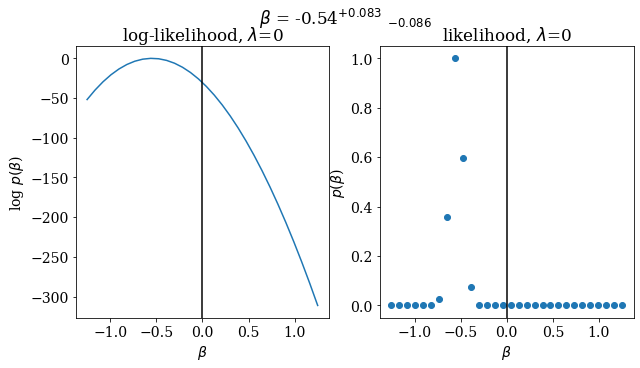

In [52]:
print("most likely beta (IN SOURCE FRAME) =",med_beta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(beta_range_lam_0, log_beta_norm_lam_0)
axes[0].axvline(x=beta_inj, color='k')
axes[0].set_ylabel("log $p(\\beta$)")
axes[0].set_xlabel("$\\beta$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].scatter(beta_range_lam_0, np.exp(log_beta_norm_lam_0))
axes[1].axvline(x=beta_inj, color='k')
axes[1].set_ylabel("$p(\\beta$)")
axes[1].set_xlabel("$\\beta$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\beta$ = {med_beta:.2f}$^{{+{sig_pos_beta-med_beta:.3f}}}$ $_{{{sig_neg_beta - med_beta:.3f}}}$", y=0.99)
# plt.tight_layout()

plt.savefig(plotdir+f'N_{len(m1_mu_detections)}_beta_{beta_inj:.1f}_hyper_posterior_lam_0.pdf')
plt.show()

-0.3789, -0.4273

### $\lambda=1$, $\beta$ posterior

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True, bias_index=1, injected=False)
m2_mu_sampled, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=True, bias_index=1, injected=False)

In [ ]:
beta_min = beta_inj-2.5
beta_max = beta_inj+5.5
n_beta = 20

beta_range_lam_1 = np.linspace(beta_min, beta_max, n_beta)

In [ ]:
log_p_beta_lam_1_src, beta_range_lam_1 = log_likelihood_beta(m1_mu_sampled, m1_sigma_events, m2_mu_sampled, m2_sigma_events,      
    beta_min=beta_min, beta_max=beta_max, n_beta=n_beta, \
    alpha=alpha_inj, \
    m1_min_pow=mmin_inj, m1_max_pow=mmax_inj,\
    m1_min_int = mmin_inj, m1_max_int=50.0, n_m1_int=300, n_m2_int=100, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))


log_beta_norm_lam_1 =log_p_beta_lam_1_src - np.max(log_p_beta_lam_1_src)

In [ ]:
# 68% confidence interval using KDE
med_beta, sig_pos_beta, sig_neg_beta = get_cofidence_int_1d(log_beta_norm_lam_1, beta_range_lam_1)

print(f"68% Confidence interval: {sig_neg_beta}, {med_beta}, {sig_pos_beta}")
bias_sigma = (med_beta-beta_inj)/(sig_pos_beta-med_beta)
print(rf"Injected beta is {bias_sigma:.3f} sigma away")


In [ ]:
print("most likely beta (IN SOURCE FRAME) =",med_beta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(beta_range_lam_1, log_beta_norm_lam_1)
axes[0].axvline(x=beta_inj, color='k')
axes[0].set_ylabel("log $p(\\beta$)")
axes[0].set_xlabel("$\\beta$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(beta_range_lam_1, np.exp(log_beta_norm_lam_1))
axes[1].axvline(x=beta_inj, color='k')
axes[1].set_ylabel("$p(\\beta$)")
axes[1].set_xlabel("$\\beta$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\beta$ = {med_beta:.2f}$^{{+{sig_pos_beta-med_beta:.3f}}}$ $_{{{sig_neg_beta - med_beta:.3f}}}$", y=0.99)
# plt.tight_layout()


# plt.savefig(plotdir+f'N_{len(q_mu_sampled)}_beta_{beta_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

## Some tests

In [ ]:
mass1 = m1_mu_sampled
mass2 = m2_mu_sampled

mass1, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False, bias_index=1, injected=True)
mass2, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=False, bias_index=1, injected=True)

m1_test = 9.0
mask_m1 = (mass1 > m1_test*0.99) * (mass1 < m1_test*1.01)
print(np.sum(mask_m1))

plt.hist(mass2[mask_m1], histtype='step', density=True);

# x = np.linspace(5.0, m1_test, 10)
# plt.axhline(y=1.5, linestyle="--")
# plt.plot(x, 5*x**(-0.3), linestyle='--')

# 2D inference (Manual)

In [ ]:
def sample(function, alpha_min=-3.7, alpha_max=-3.3, m1_min=80., m1_max=180., n_samples=10):
    alphas = np.zeros(n_samples)
    m1s = np.zeros(n_samples)
    for i in range(n_samples):
        found = False
        while not found:
            x = np.random.uniform(low=alpha_min, high=alpha_max)
            y = np.random.uniform(low=m1_min, high=m1_max)
            z = np.random.uniform(low=0.0, high=1.0)
            if z < function(x,y):
                found = True
        alphas[i] = x
        m1s[i] = y
    
    return alphas, m1s

## alpha, m1_max

In [ ]:
def log_likelihood_alpha_m1max(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=10, \
        m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
        m1_min_int=5., n_m1_int=20000, \
        m1_min_pow=5., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_max_int=m1_high_max

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)
    log_likelihoods = np.zeros((n_m1_high, n_alpha))

    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

    posteriors = np.zeros((Nt, n_m1_int))
    for i in range(Nt):
        posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])


    for m1_high_index in range(n_m1_high):
        m1_max_pow = m1_high_range[m1_high_index]

        for a in range(n_alpha):         
            alpha = alpha_range[a]

            prior = power(m1_int_range, alpha, m1_min_pow, m1_max_pow)
            log_likelihoods[m1_high_index, a] = log_integral(prior, posteriors, m1_int_range)
           
    return log_likelihoods, alpha_range, m1_high_range

In [ ]:
# def log_likelihood_alpha_m1max(m1_mu_events, m1_sigma_events, \
#     alpha_min=-4.5, alpha_max=-3, n_alpha=10, \
#         m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
#         m1_min_int=5., n_m1_int=20000, \
#         m1_min_pow=5., \
#             Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

#     m1_max_int=m1_high_max

#     alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
#     m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)

#     log_likelihoods = np.zeros((n_m1_high, n_alpha))

#     for m1_high_index in range(n_m1_high):
#         m1_max_pow = m1_high_range[m1_high_index]

#         m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
        
#         for a in range(n_alpha):
            
#             alpha = alpha_range[a]
#             total_int = 0

#             for i in range(Nt):
#                 # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
#                 # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
#                 # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
#                 integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
#                 int_term = integrate.trapezoid(integrand, m1_int_range)
#                 if int_term==0:
#                     int_term=1
                    
#                 total_int = total_int + np.log(Ns) + np.log(int_term)
                
#             log_likelihoods[m1_high_index, a] = -Ns + total_int
        
        
           
#     return log_likelihoods, alpha_range, m1_high_range

### $\lambda=0$

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [ ]:
alpha_min = alpha_inj-0.25
alpha_max=alpha_inj+0.25
n_alpha=50
m1_high_min = 80.0
m1_high_max = 180.0
n_m1_high=50

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_log_likelihoods"    


In [ ]:
log_likelihoods_a_mmax, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=5., n_m1_int=10000, \
    m1_min_pow=5.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

log_likelihoods_norm_a_mmax = log_likelihoods_a_mmax - np.max(log_likelihoods_a_mmax)

# Save likelihoods to file
if save_likelihoods:   
    np.savetxt(fname_alpha_mmax, log_likelihoods_norm_a_mmax)

In [ ]:
# # Load likelihoods from file
# log_likelihoods_norm_a_mmax = np.loadtxt(fname_alpha_mmax)

In [ ]:
index_max = np.argmax(log_likelihoods_norm_a_mmax)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

In [ ]:
# 68% confidence interval using KDE

likelihood_interp = interpolate.interp2d(alpha_range_a_mmax, m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax))

nsamples=10000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.7, alpha_max=-3.3,\
                               m1_min=80., m1_max=180., \
                                n_samples=nsamples)

samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm max}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmax_joint_likelihood_contours_lam_0.pdf")


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_LOG.pdf")
# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_EXP.pdf")
plt.show()
    


In [ ]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [ ]:
# Calculate the requisi
# te mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [ ]:
alpha_min = alpha_inj-0.7
alpha_max=alpha_inj
n_alpha=10
m1_high_min = 70.0
m1_high_max = 500.0
n_m1_high=10

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lambda_1_log_likelihoods"    


In [ ]:
log_likelihoods_a_mmax_lam_1, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=5., n_m1_int=10000, \
    m1_min_pow=5.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

log_likelihoods_norm_a_mmax_lam_1 = log_likelihoods_a_mmax_lam_1 - np.max(log_likelihoods_a_mmax_lam_1)
    
if save_likelihoods:   
    np.savetxt(fname_alpha_mmax_lam_1, log_likelihoods_norm_a_mmax_lam_1)

In [ ]:
# log_likelihoods_norm_a_mmax_lam_1 = np.loadtxt(fname_alpha_mmax_lam_1)

In [ ]:
index_max = np.argmax(log_likelihoods_norm_a_mmax_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax_lam_1.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

In [ ]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmax, m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax_lam_1))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-4.0, alpha_max=-3.6,\
                               m1_min=80., m1_max=280., \
                                n_samples=nsamples)

In [ ]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm max}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmax_joint_likelihood_contours_lam_1.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=1$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_EXP.pdf")
plt.show()
    


In [ ]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

## alpha, m1_min

In [ ]:
def log_likelihood_alpha_m1min(m1_mu_events, m1_sigma_events, \
    m2_mu_events, m2_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=50, \
    m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
    m1_min_int = 4.9, m1_max_int=200., n_m1_int=10000, \
    m1_max_pow=60., \
    beta = beta_inj,\
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros((n_m1_low, n_alpha))

    
    m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

    posteriors_m1 = np.zeros((Nt, n_m1_int))
    posteriors_m2 = np.zeros((Nt, n_m1_int))

    for i in range(Nt):
        posteriors_m1[i] = normal_dist(m_int_range, m1_mu_events[i], m1_sigma_events[i])
        posteriors_m2[i] = normal_dist(m_int_range, m2_mu_events[i], m2_sigma_events[i])


    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]

        priors_m2 = np.zeros((n_m1_int, n_m1_int))
            
        for j in range(n_m1_int):
            priors_m2[j] = power(m_int_range, beta, m1_min_pow, m_int_range[j])
            norm_p2 = integrate.trapezoid(priors_m2[j])
            if norm_p2 != 0:
                priors_m2[j] = priors_m2[j]/norm_p2
    
        for a in range(n_alpha):
            alpha = alpha_range[a]

            prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)

            integrand_m2 = jax.numpy.matmul(priors_m2, posteriors_m2.T).T

            integrands = prior_m1*posteriors_m1*integrand_m2       
            integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
            integrals = integrals[integrals!=0]

            log_likelihoods[m1_low_index, a] = np.sum(np.log(integrals))
        
        
    return log_likelihoods, alpha_range, m1_low_range

In [ ]:
# def log_likelihood_alpha_m1min(m1_mu_events, m1_sigma_events, \
#     alpha_min=-4.5, alpha_max=-3, n_alpha=50, \
#         m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#         m1_max_int=200., n_m1_int=20000, \
#         m1_max_pow=200., \
#             Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

#     alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros((n_m1_low, n_alpha))

#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
#         m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

#         for a in range(n_alpha):
            
#             alpha = alpha_range[a]
#             total_int = 0

#             for i in range(Nt):
#                 # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
#                 # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
#                 # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
#                 integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
#                 int_term = integrate.trapezoid(integrand, m1_int_range)

#                 if int_term==0:
#                     int_term=1
                    
#                 total_int = total_int + np.log(Ns) + np.log(int_term)
                
#             log_likelihoods[m1_low_index, a] = -Ns + total_int
        
        
           
#     return log_likelihoods, alpha_range, m1_low_range

### $\lambda=0$

In [ ]:
save_likelihoods=True

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)
m2_mu_sampled, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=False)

In [ ]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 20
m1_low_min = mmin_inj-0.1
m1_low_max = mmin_inj+0.1
n_m1_low= 20

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_log_likelihoods" 


In [ ]:
# log_likelihoods_norm_a_mmin, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
#     m2_mu_sampled, m2_sigma_events, \
#     alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
#     m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
#     m1_min_int=4.80, m1_max_int=mmax_inj, n_m1_int=10000, \
#     m1_max_pow=mmax_inj,\
#     beta=beta_inj,\
#     Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
# log_likelihoods_norm_a_mmin = log_likelihoods_norm_a_mmin - np.max(log_likelihoods_norm_a_mmin)

# if save_likelihoods:   
#     np.savetxt(fname_alpha_mmin, log_likelihoods_norm_a_mmin)

In [ ]:
log_likelihoods_norm_a_mmin = np.loadtxt(fname_alpha_mmin)

In [ ]:
index_max = np.argmax(log_likelihoods_norm_a_mmin)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

In [ ]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmin, m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.4, alpha_max=-3.6,\
                               m1_min=4.95, m1_max=5.05, \
                                n_samples=nsamples)

In [ ]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm min}$",
    ],
    truths=[alpha_inj, mmin_inj],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmin_joint_likelihood_contours_lam_0.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG.pdf")
# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP.pdf")
plt.show()
    
# 

In [ ]:
print("most likely m_min (IN SOURCE FRAME) =",m1_low_range_a_mmin[np.argmax(log_likelihoods_norm_a_mmin[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_a_mmin, log_likelihoods_norm_a_mmin[:,alpha_index_2d])
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log p(m_min)")
axes[0].set_xlabel("m_min")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin[:,alpha_index_2d]))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("p(m_min)")
axes[1].set_xlabel("m_min")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [ ]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [ ]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 50
m1_low_min = mmin_inj-0.50
m1_low_max = mmin_inj+0.05
n_m1_low= 50

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_lambda_1_log_likelihoods" 


In [ ]:
log_likelihoods_norm_a_mmin_lam_1, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=100., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_likelihoods_norm_a_mmin_lam_1 = log_likelihoods_norm_a_mmin_lam_1 - np.max(log_likelihoods_norm_a_mmin_lam_1)

if save_likelihoods:   
    np.savetxt(fname_alpha_mmin_lam_1, log_likelihoods_norm_a_mmin_lam_1)

In [ ]:
# log_likelihoods_norm_a_mmin_lam_1 = np.loadtxt(fname_alpha_mmin_lam_1)

In [ ]:
index_max = np.argmax(log_likelihoods_norm_a_mmin_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin_lam_1.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

In [ ]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmin, m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin_lam_1))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.5, alpha_max=-3.3,\
                               m1_min=4.5, m1_max=4.7, \
                                n_samples=nsamples)

In [ ]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm min}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmin_joint_likelihood_contours_lam_1.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=1$")


# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG_lam_1.pdf")
# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP_lam_1.pdf")
plt.show()
    
# 

# 3D Inference, MCMC test

https://github.com/kazewong/TutorialsAndExplains/blob/main/HBA_explain/Session_version.ipynb

In [125]:
import emcee
import corner
import jax

In [ ]:
# m1_min_int = 4.9
# m1_max_int= 60.
# n_m1_int= 4000

# m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)
# m2_mu_sampled, m2_sigma_events = sample_m2_events(df_mc, df_eta, biased=False)

# Ns = len(m1_mu_sampled)
# Nt = Ns

# m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

# posteriors_m1 = np.zeros((Nt, n_m1_int))
# posteriors_m2 = np.zeros((Nt, n_m1_int))

# priors_m2 = np.zeros((n_m1_int, n_m1_int))

# for i in range(Nt):
#     posteriors_m1[i] = normal_dist(m_int_range, m1_mu_sampled[i], m1_sigma_events[i])
#     posteriors_m2[i] = normal_dist(m_int_range, m2_mu_sampled[i], m2_sigma_events[i])

In [147]:
m1_min_int = 4.5
m1_max_int= 80.
n_m1_int= 500


m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc, df_eta)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

Ns = len(m1_mu_sampled)
Nt = Ns

m_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

posteriors_m1 = np.zeros((Nt, n_m1_int))
posteriors_m2 = np.zeros((Nt, n_m1_int, n_m1_int))


for i in range(Nt):
    posteriors_m1[i] = normal_dist(m_int_range, m1_mu_sampled[i], np.sqrt(covariances[i][0,0]))
    for j in range(n_m1_int):
        posteriors_m2[i,j] = bivariate_normal_dist(m_int_range[j], m_int_range, m1_mu_sampled[i], m2_mu_sampled[i], covariances[i])

In [56]:
# # set the prior (m1_range, m2_range)
# prior_m2_full = power(m_int_range, beta_inj, mmin_inj, m_int_range[-1])
# prior_m2 = np.tri(len(m_int_range), len(m_int_range)) * prior_m2_full
# norm = integrate.trapezoid(prior_m2, m_int_range, axis=1)
# norm[np.where(norm==0)]=1.0
# prior_m2 = prior_m2 / norm[:, np.newaxis]

# prior_m2.shape


(500, 500)

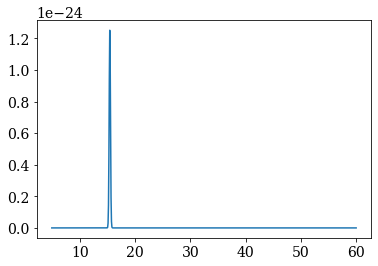

In [115]:
# integral_m2 = np.zeros((Nt, n_m1_int))

# for j in range(len(m_int_range)):
#     for i in range(Nt):
#         integral_m2[i,j] = integrate.trapezoid(prior_m2[j] * posteriors_m2[i,j], m_int_range)
#         if i == 7 and j ==250:
#             plt.plot(m_int_range, prior_m2[j] * posteriors_m2[i,j])

In [116]:
# print(integral_m2.shape)
# integral_m2[7][250]

(200, 500)


3.6355645805014998e-25

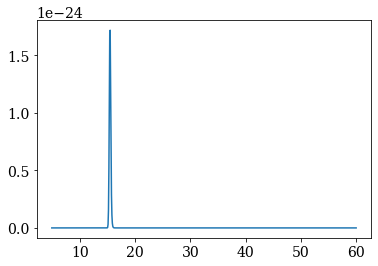

In [120]:
# # posterior_2d = np.reshape(posteriors_m2, (Nt, n_m1_int*n_m1_int))
# # integral_test = np.matmul(posteriors_m2, prior_m2.T)
# integral_test = jax.numpy.matmul(prior_m2.T, posteriors_m2)
# plt.plot(m_int_range, integral_test[7][250])

# integral_test = integrate.trapezoid(integral_test, m_int_range, axis=2)

In [121]:
# print(integral_test.shape)
# integral_test[7][250]

(200, 500)


5.9170420441720045e-25

In [148]:
np.min(m1_mu_sampled)

-390.77272881860057

In [ ]:
# def lnprob(hyper):
#     alpha = hyper[0]
#     m1_min_pow = hyper[1]
#     m1_max_pow = hyper[2]
#     beta = beta_inj

#     for j in range(n_m1_int):
#         priors_m2[j] = power(m_int_range, beta, m1_min_pow, m_int_range[j])
#         norm_p2 = integrate.trapezoid(priors_m2[j])
#         if norm_p2 != 0:
#             priors_m2[j] = priors_m2[j]/norm_p2
    
#     integrand_m2 = jax.numpy.matmul(priors_m2 ,posteriors_m2.T).T

#     prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
#     # make sure the prior is normalized 
#     # (becomes a problem with geomspaced bins where the first few numbers are 0s)
#     # prior = prior / integrate.trapezoid(prior, m_int_range)
#     prior_m1 = prior_m1 / jax.numpy.trapz(prior_m1, m_int_range)

#     integrands = prior_m1*posteriors_m1*integrand_m2 

#     # integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
#     integrals = jax.numpy.trapz(integrands, m_int_range, axis=1)
    
#     integrals = integrals[integrals!=0]
    
#     return np.sum(np.log(integrals))

In [149]:
def lnprob(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    beta = beta_inj

    integrand_m2 = np.zeros((Nt, n_m1_int))

    prior_m2_full = power(m_int_range, beta, m1_min_pow, m_int_range[-1])
    prior_m2 = np.tri(len(m_int_range), len(m_int_range)) * prior_m2_full
    norm = integrate.trapezoid(prior_m2, m_int_range, axis=1)
    norm[np.where(norm==0)]=1.0
    prior_m2 = prior_m2 / norm[:, np.newaxis]
        
    integrand_m2 = jax.numpy.matmul(prior_m2.T, posteriors_m2)
    integrand_m2 = integrate.trapezoid(integrand_m2, m_int_range, axis=2)
    

    prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
    # make sure the prior is normalized 
    # (becomes a problem with geomspaced bins where the first few numbers are 0s)
    # prior = prior / integrate.trapezoid(prior, m_int_range)
    prior_m1 = prior_m1 / jax.numpy.trapz(prior_m1, m_int_range)

    integrands = prior_m1*integrand_m2*posteriors_m1

    integrals = jax.numpy.trapz(integrands, m_int_range, axis=1)
    
    integrals = integrals[integrals!=0]
    
    return np.sum(np.log(integrals))


In [138]:
#  m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

#     m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

#     priors_m2 = np.zeros((n_m1_int, n_m1_int))

#     posteriors_m1 = np.zeros((Nt, n_m1_int))    
#     posteriors_m2 = np.zeros((Nt, n_m1_int))

#     for m1_low_index, m1_low in enumerate(m1_low_range):

#         priors_m2 = np.zeros((n_m1_int, n_m1_int))

#         posteriors_m1 = np.zeros((Nt, n_m1_int))
#         posteriors_m2 = np.zeros((Nt, n_m1_int))

#         prior_m1 = power(m_int_range, alpha, m1_low, m1_max_pow)
#         prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)


#         for j in range(n_m1_int):
#             priors_m2[j] = power(m_int_range, beta, m1_low, m_int_range[j])


#         for i in range(Nt):
#             posteriors_m1[i] = normal_dist(m_int_range, m1_mu_events[i], m1_sigma_events[i])
#             posteriors_m2[i] = normal_dist(m_int_range, m2_mu_events[i], m2_sigma_events[i])

        
#         # this block of code actually works, confirmed (although it 'integrates' along m2 using np.sum())
#         integrand_m2 = np.matmul(priors_m2 ,posteriors_m2.T).T

#         integrands = prior_m1*posteriors_m1*integrand_m2       

#         integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
#         integrals = integrals[integrals!=0]
#         log_likelihoods[m1_low_index] = np.sum(np.log(integrals))

        
#     return log_likelihoods, m1_low_range

In [150]:
def population_posterior(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    beta = beta_inj

    if (alpha>-1.0) or (alpha<-5.0):
        return -np.inf
    if (m1_min_pow>5.5) or (m1_min_pow<4.5):
        return -np.inf
    if (m1_max_pow>100.0) or (m1_max_pow<40.0):
        return -np.inf
    if (beta>1.0) or (beta<-2.5):
        return -np.inf

    else:
        return lnprob(hyper)

In [151]:
hyper_test = [-3.5, 4.97, 61.4]

start = time.time()
print(population_posterior(hyper_test))
end = time.time()

print(f"Time: {end-start:.5f} s")

-23009.133
Time: 65.02140 s


In [152]:
ndim, nwalkers = 3, 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior)

p0 = np.random.uniform([-3.4, 4.99, 55], [-3.6, 5.01, 65], size=(nwalkers,ndim))

# burn-in sampler:
state = sampler.run_mcmc(p0, 50, progress=True)
sampler.reset()


  2%|▏         | 1/50 [11:47<9:37:54, 707.64s/it]

In [ ]:
N_MCMC = 100

# explore parameter space:
state = sampler.run_mcmc(state, N_MCMC, progress=True)

100%|██████████| 100/100 [08:12<00:00,  4.93s/it]


In [ ]:
# get flat results:
flat_samples = sampler.get_chain(discard=50, flat=True)

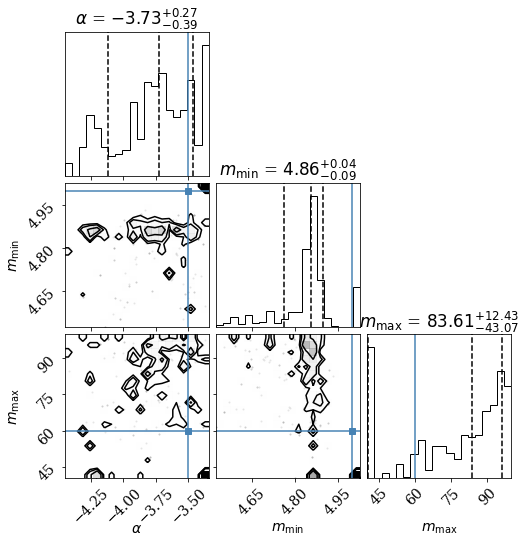

In [144]:
# samples
fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj],\
                    labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$"],\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True,)
# plt.savefig(plotdir + f"3D_ N_MCMC_{N_MCMC}.pdf")

In [145]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

alpha_mcmc, mmin_mcmc, mmax_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(alpha_mcmc)
print(mmin_mcmc)
print(mmax_mcmc)

(-3.729996027533345, 0.2657745448490991, 0.3926868154652454)
(4.855454035981564, 0.04193495931721447, 0.09305480030684699)
(83.60526211157834, 12.433160219999735, 43.073757708797224)


# Scipy curve_fit test

In [72]:
# m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc, df_eta, injected=False)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


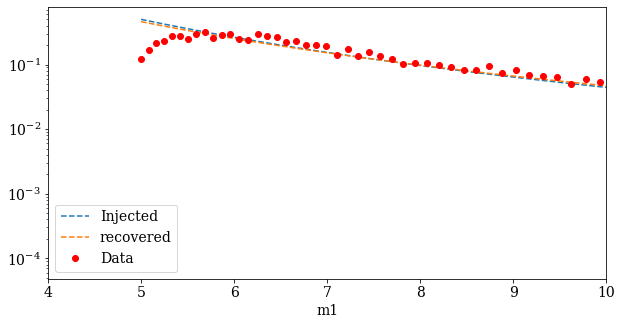

[-3.5  5.  60. ]


In [73]:
target_func = power
bins = np.geomspace(5.0, 120, 200)

y, X = np.histogram(m1_mu_sampled, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()


popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.5, 5.0, 60.0])

plt.figure(figsize=(10, 5))

plt.plot(X, power(X,  alpha_inj, mmin_inj, mmax_inj), '--', label='Injected')



# plt.plot(X, target_func(X, *popt), '--', label='Scipy Fit')
plt.plot(X, power(X,  -3.3, mmin_inj, mmax_inj), '--', label='recovered')



plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.semilogy()
plt.legend()

plt.xlim(4.0, 10)

plt.show()


print(popt)

In [68]:
np.min(m1_mu_sampled)

5.001125623332574

# Alpha Bias vs N_det

In [ ]:
def get_avg_sigma_boot(n_samples, n_bootstrap):

    n_samples = int(n_samples)

    sigma_devs_boot = np.zeros(n_bootstrap)

    for n in range(n_bootstrap):
        
        sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
        df_mc = df_mc_raw.iloc[sample_indices]
        df_eta = df_eta_raw.iloc[sample_indices]

        # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
        z = df_mc["z"]
        mchirp = (df_mc["Mc"])/ (1+z)
        eta = df_mc["eta"]

        sigMc_raw = df_mc["Mc_stat_err"]
        sigEta = df_eta["eta_stat_err"]
        sigZ = df_mc["z_stat_err"]

        sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


        aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
        aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
        aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
        aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
        m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
        m1_sigma_events = m1_sigma_events.values


        # Use biased mc, eta for the m1_mu list only
        bias_eta = df_eta["bias_19"]
        bias_mc = df_mc["bias_19"]

        mchirp = (df_mc["Mc"] + bias_mc)
        eta = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_biased = conv.mass1_from_mchirp_eta(mchirp, eta)
        m1_mu_detections = m1_biased / (1+z)
        # sample mu from the detection gaussians to avoid Biases
        m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

        log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
        alpha_min=alpha_inj-1.0, alpha_max=alpha_inj+0.5, n_alpha=30, \
        m1_min_int = 5., m1_max_int=200., n_m1_int=20000,\
        m1_min_pow = 5., m1_max_pow=100.,\
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
        log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)   


        target_func = normal_dist
        y, X = np.exp(log_alpha_norm), alpha_range_src
        popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

        mu_alpha = popt[0]
        sig_alpha = popt[1]
        sigma_devs_boot[n] = np.abs(alpha_inj - mu_alpha)/sig_alpha
        # print(rf"Injected alpha is {sigma_devs_boot[n] :.2f} sigma away")

    print(rf"For N = {n_samples} detections, injected alpha is {np.average(sigma_devs_boot) :.2f} sigma away on avg.")
    return np.median(sigma_devs_boot), np.std(sigma_devs_boot)

In [ ]:
N_samples_range = [10., 25., 50., 100., 150.]
med_sigma_boot_range = np.zeros(len(N_samples_range))
std_sigma_boot_range = np.zeros(len(N_samples_range))

In [ ]:
med_sigma_boot_range[0], std_sigma_boot_range[0] = get_avg_sigma_boot(n_samples=N_samples_range[0], n_bootstrap=100)

In [ ]:
med_sigma_boot_range[1], std_sigma_boot_range[1] = get_avg_sigma_boot(n_samples=N_samples_range[1], n_bootstrap=100)

In [ ]:
med_sigma_boot_range[2], std_sigma_boot_range[2] = get_avg_sigma_boot(n_samples=N_samples_range[2], n_bootstrap=100)

In [ ]:
med_sigma_boot_range[3], std_sigma_boot_range[3] = get_avg_sigma_boot(n_samples=N_samples_range[3], n_bootstrap=100)

In [ ]:
med_sigma_boot_range[4], std_sigma_boot_range[4] = get_avg_sigma_boot(n_samples=N_samples_range[4], n_bootstrap=100)

In [ ]:
fig, axes = plt.subplots(figsize=(6, 5))
plt.errorbar(N_samples_range, med_sigma_boot_range, yerr=std_sigma_boot_range, fmt='o', capsize=5.0)
plt.xlabel("N")
plt.ylabel("Median $\\alpha$ bias ($\sigma$)")
plt.grid()
# plt.semilogy()
# plt.savefig(plotdir+'alpha_3.5_lam_1_n_vs_bias.pdf')
plt.show()

# ChatGPT Stuff

I asked, "what is the integral of x^(-n) multiplied by a gaussian over x, over a range a to b, where n is a positive number?"

It replied:
The integral of $x^{-n}$ multiplied by a Gaussian over x, over a range a to b, where n is a positive number and the first term is normalized over the integration range, can be expressed as:

$$\int_a^b \frac{1}{x^n} e^{-\frac{(x-\mu)^2}{2\sigma^2}} dx$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the Gaussian, respectively.

This integral does not have a closed-form solution in terms of elementary functions, but it can be expressed in terms of the incomplete gamma function $\Gamma(n,x)$ as follows:

$$\int_a^b \frac{1}{x^n} e^{-\frac{(x-\mu)^2}{2\sigma^2}} dx = \frac{1}{2} \left[\Gamma\left(\frac{n-1}{2},\frac{(a-\mu)^2}{2\sigma^2}\right) - \Gamma\left(\frac{n-1}{2},\frac{(b-\mu)^2}{2\sigma^2}\right)\right]$$

where $\Gamma(s,x)$ is the incomplete gamma function defined as:

$$\Gamma(s,x) = \int_x^\infty t^{s-1} e^{-t} dt$$

Note that this expression assumes $a > 0$ and $b > 0$. If either $a$ or $b$ is zero, the integral diverges and must be handled separately. If both $a$ and $b$ are zero, the integral is undefined.

If you are working in Python, you can evaluate the incomplete gamma function using the scipy.special.gammainc function in the scipy library. Here's an example code snippet that evaluates the integral for specific values of $a$, $b$, $\mu$, $\sigma$, and $n$:

In [ ]:
import scipy.special as sp

def integral_of_powerlaw_times_gaussian(alpha, mu, sigma, a, b):
    prefactor = 0.5
    term1 = sp.gammainc((alpha-1)/2, (a-mu)**2 / (2*sigma**2))
    term2 = sp.gammainc((alpha-1)/2, (b-mu)**2 / (2*sigma**2))
    return prefactor * (term1 - term2)


In [ ]:
import numpy as np
from scipy.special import gammainc

a = mmin_inj
b = mmax_inj
mu = m1_mu_sampled[0]
sigma = m1_sigma_events[0]
n = 3.5

integral = 0.5 * (gammainc((n-1)/2, (a-mu)**2/(2*sigma**2)) -
                  gammainc((n-1)/2, (b-mu)**2/(2*sigma**2)))
integral

In [ ]:
print(integral_of_powerlaw_times_gaussian(3.5, m1_mu_sampled[0], m1_sigma_events[0], mmin_inj, mmax_inj))

m1 = np.geomspace(mmin_inj, mmax_inj, 1000000)
prior_m1 = m1**(-3.5)
posterior = normal_dist(m1, m1_mu_sampled[0], m1_sigma_events[0])
integrate.trapezoid(prior_m1 * posterior, m1)
